<a href="https://colab.research.google.com/github/ThierrryScotto/Air-Passengers-Forecast/blob/main/air_passengers_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [3]:
dataset = pd.read_csv("/content/AirPassengers.csv")

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### Parse strings to datetype

In [6]:
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexed_dataset = dataset.set_index(['Month'])

In [8]:
indexed_dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [9]:
from datetime import datetime
indexed_dataset.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### plot graph

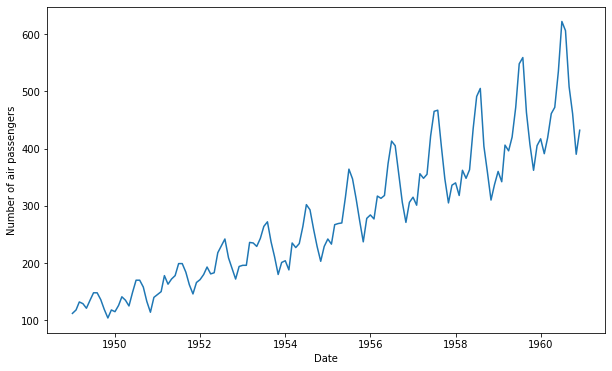

In [10]:
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
plt.plot(indexed_dataset)

## Determing rolling statistics

In [15]:
rolmean = indexed_dataset.rolling(window=12).mean()
rolstd = indexed_dataset.rolling(window=12).std()
print(rolmean, rolstd)

            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


### Plot rolling statistics

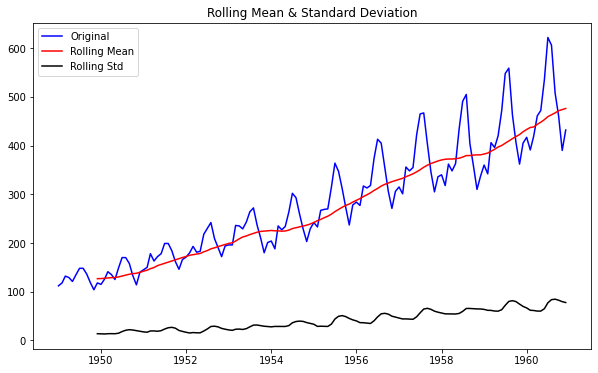

In [18]:
orig = plt.plot(indexed_dataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Perform Dickey-Fuller test

In [22]:
from statsmodels.tsa.stattools import adfuller

print('Result of Dickey-Fuller Test')
df_test = adfuller(indexed_dataset['Passengers'], autolag='AIC')

df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations used'])
for key, value in df_test[4].items():
  df_output['Critical Value (%s)'%key] = value

print(df_output)

Result of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Estimating trend

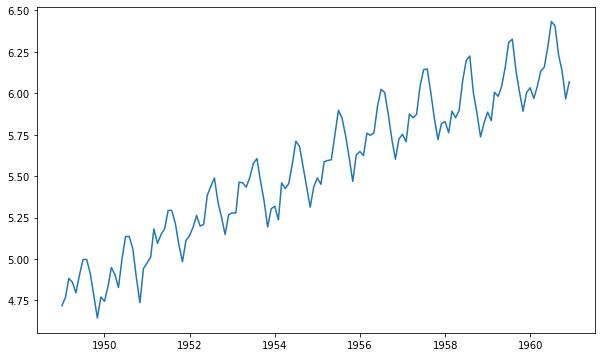

In [25]:
indexed_dataset_log_scale = np.log(indexed_dataset)
plt.plot(indexed_dataset_log_scale)

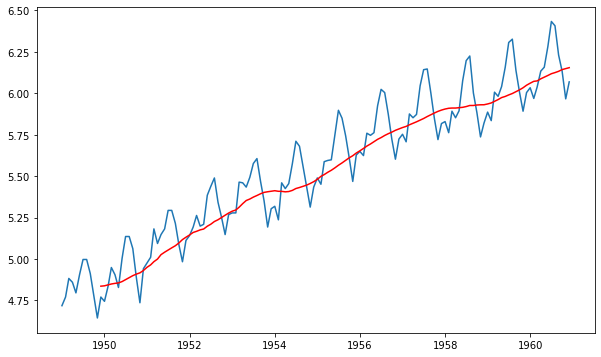

In [27]:
moving_average = indexed_dataset_log_scale.rolling(window=12).mean()
moving_std = indexed_dataset_log_scale.rolling(window=12).std()
plt.plot(indexed_dataset_log_scale)
plt.plot(moving_average, color='red')

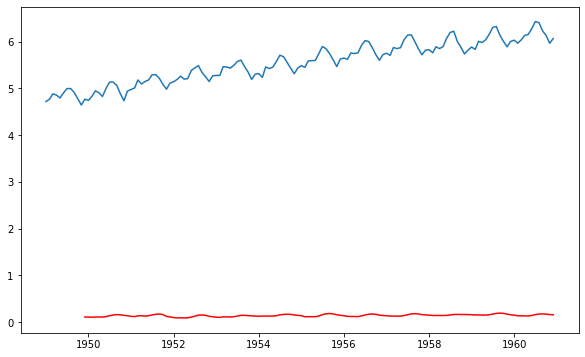

In [28]:
plt.plot(indexed_dataset_log_scale)
plt.plot(moving_std, color='red')